## Implementation

The aim here is to use Naive Bayes to predict in which range of year the song is from base on it's acoustic features.

In [394]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [393]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import random
from sklearn import metrics

In [369]:
import time

In [370]:
# load data
data = pd.read_csv('../data/01-modified-data/top50MusicFrom2010-2019_cleaned.csv')

In [371]:
# Creaet a training method
def train_and_test(x_train, y_train, x_test, y_test, i_print=False):

    gnb = GaussianNB()
    start = time.process_time()
    gnb.fit(x_train, y_train)
    end = time.process_time()
    time_train = end - start
    start = time.process_time()
    y_pred = gnb.predict(x_test)
    end = time.process_time()
    time_eval = end - start
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, gnb.predict(x_train))
    # f1 = f1_score(y_test, y_pred, pos_label='2010-2014')
    if i_print:
        print(accuracy*100, accuracy_train*100) 
    
    return accuracy_train, accuracy, time_train, time_eval


In [427]:
X = data.drop(['year', 'year_group', 'genre', 'title', 'artist'], axis=1)
y = data['year_group'].values

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [429]:
train_and_test(X_train, y_train, X_test, y_test, i_print=True)

59.50413223140496 65.56016597510373


(0.6556016597510373,
 0.5950413223140496,
 0.004610999999997034,
 0.0021029999999981897)

We can see the initial testing result is 59% and it's not good enough. We will try to improve it using feature selection.

In [375]:
N=X.shape[0]
l = [*range(N)]       # indices
cut = int(0.7 * N)    # 80% of the list
random.shuffle(l)     # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:]  # last 20% of shuffled list

## Feature Selection for record data (Using Variance Threshold)

In [376]:
# VARIANCE THRESHOLD SEARCH

from sklearn.feature_selection import VarianceThreshold

x_var=np.var(X,axis=0)
# DEFINE GRID OF THRESHOLDS 
num_thresholds=10
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

# DOESN"T WORK WELL WITH EDGE VALUES (ZERO VAR)
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
num_features=[]
train_accuracies=[]
test_accuracies=[]
train_time = []
eval_time = []

#FULL TRAINING SET

(acc_train,acc_test, time_train, time_eval)=train_and_test(X_train,y_train,X_test,y_test,i_print=True)
num_features.append(X.shape[1])
train_accuracies.append(acc_train)
test_accuracies.append(acc_test)
train_time.append(time_train)
eval_time.append(time_eval)

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(X)
    print(THRESHOLD, xtmp.shape[1])

    x_train=xtmp[train_index]; y_train=y[train_index]
    x_test=xtmp[test_index]; y_test=y[test_index]


    (acc_train,acc_test, time_train, time_eval)=train_and_test(x_train,y_train,x_test,y_test,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)



59.50413223140496 65.56016597510373
136.16184967918835 7
264.507765209332 5
392.8536807394756 4
521.1995962696192 2
649.5455117997628 1
777.8914273299064 1
906.23734286005 1


In [377]:
eval_time

[0.0005700000000032901,
 0.00014000000000180535,
 0.00015100000000245473,
 0.00010799999999733245,
 0.00011200000000144428,
 9.800000000126374e-05,
 0.00010000000000331966,
 9.299999999967667e-05]

In [378]:
num_features

[9, 7, 5, 4, 2, 1, 1, 1]

In [379]:
#UTILITY FUNCTION TO PLOT RESULTS
def plot_results():

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (red) and Test (blue)')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.show()

In [380]:
max(test_accuracies)

0.6574585635359116

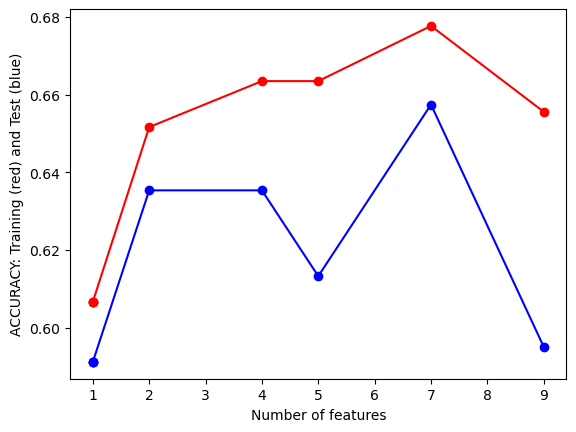

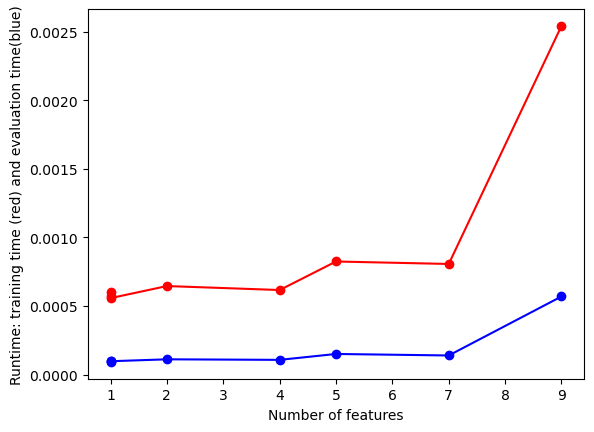

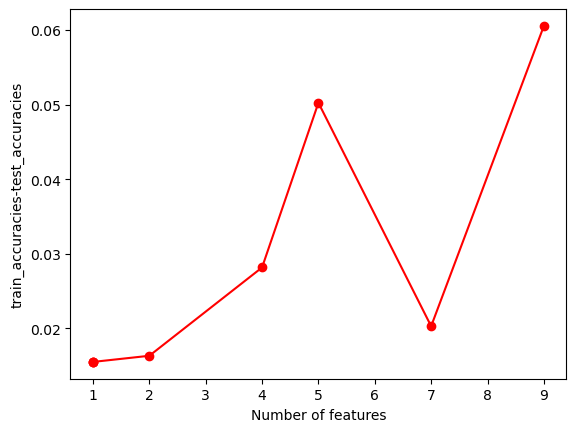

In [381]:
plot_results()

1. The first graph shows the performance of the model's trend during the added features. Both the training and testing accuarcy were at peak when the feature number is 9 (all of them), which should be the best number of features to use. The best accuarcy it can give is about 0.68. The interesting thing is that the accuarcy of training are lower than the testing accuarcy. It could be a result of underfitting due to the lack of features or simple nature of naive bayes.

2. This graph shows the time used for training and testing related to the number of the features. It can be observed that after the feature number is greater than 7 the time consumption for training and testing increased dramatically. Therefore, 7 is the best number for reducing time cost.

3. This graph shown how the difference of the accuarcy between the training and testing change according to the number of features. It can be observed that the difference is quite low when the feature number is 7 and and 1. 

## Feature Selection for record data (Using iterative feature selection)

In [382]:
import itertools

In [414]:
def maximize_CFS(x,y):
     
     df_x = x
     column_names = df_x.columns

     N=X.shape[0]
     l = [*range(N)]       # indices
     cut = int(0.7 * N)    # 80% of the list
     random.shuffle(l)     # randomize
     train_index = l[:cut] # first 80% of shuffled list
     test_index = l[cut:]  # last 20% of shuffled list

     max_accuracy = 0
     y_train=y[train_index]
     y_test=y[test_index]
     
     for L in range(1,len(column_names) + 1):
          for subset in itertools.combinations(column_names, L):
               # print(df_x[list(subset)].values.shape)
               temp = df_x[list(subset)]
               x_train=temp.iloc[train_index]
               x_test=temp.iloc[test_index]
               _, accuracy, _, _ = train_and_test(x_train, y_train, x_test, y_test)
               if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    max_subset = list(subset)
                    print(f'found new max: {max_accuracy}  optimal features = {max_subset} \niteration= {L}, accuarcy = {accuracy}')
          
     
     return max_accuracy, max_subset, y_test, x_test, y_train, x_train

In [415]:
acc, subset, y_test, x_test, y_train, x_train = maximize_CFS(X,y)

found new max: 0.585635359116022  optimal features = ['beat'] 
iteration= 1, accuarcy = 0.585635359116022
found new max: 0.5966850828729282  optimal features = ['danceability'] 
iteration= 1, accuarcy = 0.5966850828729282
found new max: 0.6408839779005525  optimal features = ['popularity'] 
iteration= 1, accuarcy = 0.6408839779005525
found new max: 0.6519337016574586  optimal features = ['duration', 'popularity'] 
iteration= 2, accuarcy = 0.6519337016574586
found new max: 0.6574585635359116  optimal features = ['beat', 'duration', 'popularity'] 
iteration= 3, accuarcy = 0.6574585635359116
found new max: 0.6629834254143646  optimal features = ['energy', 'duration', 'popularity'] 
iteration= 3, accuarcy = 0.6629834254143646
found new max: 0.6685082872928176  optimal features = ['beat', 'danceability', 'duration', 'popularity'] 
iteration= 4, accuarcy = 0.6685082872928176
found new max: 0.6740331491712708  optimal features = ['beat', 'valence', 'duration', 'popularity'] 
iteration= 4, acc

In [416]:
acc

0.7071823204419889

In [417]:
subset

['beat', 'danceability', 'valence', 'duration', 'popularity']

Using the iterative feature selection, the best features combination were selected and the accuarcy is higher than using the variance threshold in the last case. So I will use this as the final result.

## Final Result

In [423]:
def generate_final_result(x_train, y_train, x_test, y_test):

    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, gnb.predict(x_train))
    f1 = f1_score(y_test, y_pred, pos_label='2010-2014')

    
    return f1, accuracy, accuracy_train, y_pred, y_test


In [424]:
f1, accuarcy, accuracy_train, y_pred, y_test = generate_final_result(x_train[subset], y_train, x_test[subset], y_test)

In [420]:
f1

0.7665198237885462

In [421]:
accuarcy

0.7071823204419889

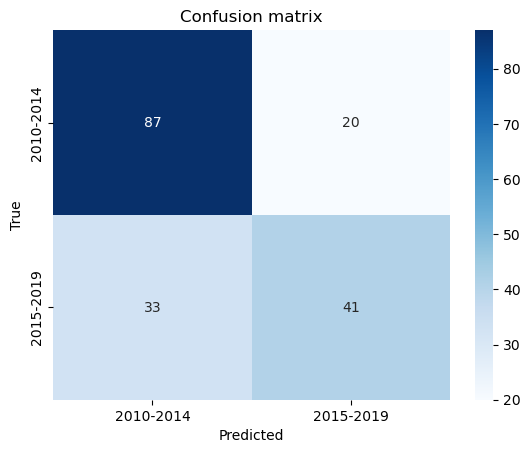

In [422]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=['2010-2014', '2015-2019'])

plt.title("Confusion matrix")
axis = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
axis.set_xticklabels(['2010-2014', '2015-2019'])
axis.set_yticklabels(['2010-2014', '2015-2019'])
axis.set(xlabel="Predicted", ylabel="True")
plt.show()

According to the confusion matrix, this model would violently biased to the case of 2010-2014. This could be a result of the lack of data in general. Though the accuracy is not bad but the model is not very useful in practice because of the high bias.

## Discussion

1. The modle was trained using the sklern inbulit GaussianNB function. Using the fit method to train on the training dataset and predict method to test on the test set. 

1. The model has a good accuarcy but a terrible recall for class 2010-2014. So although the model can predict the year of the song. The F1 score for class 2010-2014 is decent but for another class is not pretty satisfying.This could be the result of the lack of data in general.

2. Overfitting is when the model is too complex to learn even the noise of the training data, while underfitting is when the model is too simple and fail to learn the pattern at all. While overfitting has a high variance and low bias while overfitting could have low variance and high bias. In this case, due to the high bias, the model is more likely to be underfitting.

3. The project finds that there is a possible way to use the acoustic features of a song to roughly decide its year of release. If there is a need for a report, this should be documented using like a R markdown or Jupyter notebook so the result is reproduceable. What should be reported include how the modle was trained, what is the dataset, the result and the limitation. 